In [ ]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [46]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-08-13 hTERT SPH number test"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                         FileName_RGB  ImageNumber
0   2024-08-13 RZ hTERT SPH Number 34_49_57 0H (Mu...            1
1   2024-08-13 RZ hTERT SPH Number 34_49_57 1H (Mu...            2
2   2024-08-13 RZ hTERT SPH Number 34_49_57 24H (M...            3
3   2024-08-13 RZ hTERT SPH Number 34_49_57 2H (Mu...            4
4   2024-08-13 RZ hTERT SPH Number 34_49_57 3H (Mu...            5
5   2024-08-13 RZ hTERT SPH Number 34_49_57 48H (M...            6
6   2024-08-13 RZ hTERT SPH Number 34_49_57 4H (Mu...            7
7   2024-08-13 RZ hTERT SPH Number 34_49_57 72H (M...            8
8   2024-08-13 RZ hTERT SPH Number 7_17_25 0H (Mul...            9
9   2024-08-13 RZ hTERT SPH Number 7_17_25 1H (Mul...           10
10  2024-08-13 RZ hTERT SPH Number 7_17_25 24H (Mu...           11
11  2024-08-13 RZ hTERT SPH Number 7_17_25 2H (Mul...           12
12  2024-08-13 RZ hTERT SPH Number 7_17_25 3H (Mul...           13
13  2024-08-13 RZ hTERT SPH Number 7_17_25 48H (Mu...         

Extract wellmaps and combine into one df with names of the images

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-08-13 hTERT SPH number test\2024-08-13 RZ hTERT SPH Number 34_49_57 0H (Multichannel).toml


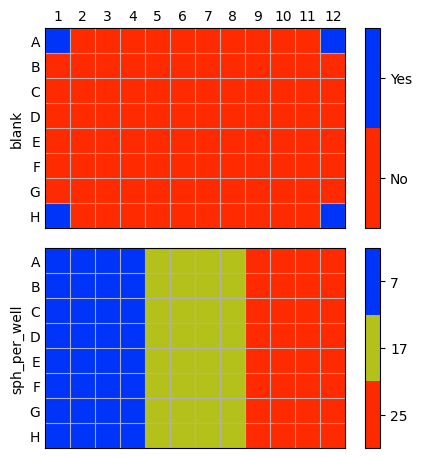

In [47]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [48]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

     row  col
0      A    1
1      B    1
2      C    1
3      D    1
4      E    1
...   ..  ...
1531   D   12
1532   E   12
1533   F   12
1534   G   12
1535   H   12

[1536 rows x 2 columns]


Misceleneous

In [49]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank',
       'sph_per_well', 'cells', 'uv', 'RZ_incubation', 'culture_type',
       'plate_number'],
      dtype='object')


In [61]:
plate_list = data_plate['plate_number'].unique()
RZ_incubation_list = data_plate['RZ_incubation'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(plate_list)

for i in plate_list:
    data_plate_i = data_plate[(data_plate['plate_number'] == i)]

    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0')]
    reference_plate = reference_plate.reset_index(drop=True)
    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    for y in RZ_incubation_list:

        sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] == y)]

        sample_plate = sample_plate.reset_index(drop=True)
        
        sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


        data_plate_corrected = data_plate_corrected.append(sample_plate)

print(data_plate_corrected)

['2' '1']
   row col  ImageNumber  ObjectNumber  \
0    A   1            1             1   
1    B   1            1             2   
2    C   1            1             3   
3    D   1            1             4   
4    E   1            1             5   
..  ..  ..          ...           ...   
91   D  12           16            92   
92   E  12           16            93   
93   F  12           16            94   
94   G  12           16            95   
95   H  12           16            96   

    Intensity_IntegratedIntensity_OrigGreen  \
0                                 78.329415   
1                                 73.384316   
2                                 77.133336   
3                                 76.305885   
4                                 75.411768   
..                                      ...   
91                              2241.980447   
92                              2013.337311   
93                              2266.894170   
94                         

C:\Users\Modern\AppData\Local\Temp\ipykernel_12268\3695711053.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_12268\3695711053.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_12268\3695711053.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_plate_corrected = data_plate_corrected.append(sample_plate)
C:\Users\Modern\AppData\Local\Temp\ipykernel_12268\3695711053.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 96.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 92.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 45.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Package

['34' '49' '57' '7' '17' '25']


C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 70.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


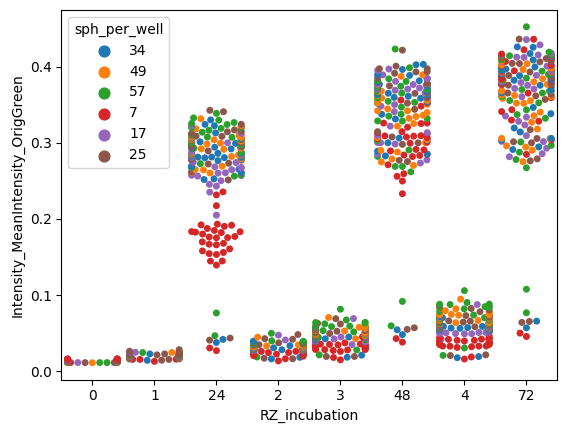

In [63]:
ay = sns.swarmplot(data=data_plate_corrected, x="RZ_incubation", y="Intensity_MeanIntensity_OrigGreen", hue = 'sph_per_well')
print(data_plate['sph_per_well'].unique())

In [64]:
blank_array = []

plate_list = data_plate_corrected['FileName_RGB'].unique()
print(plate_list)

for p in plate_list:
    blank_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') & 
                                   (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
    
    blank_std_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') 
                                       & (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

    bc_array_i = [blank_p, blank_std_p ,p]

    print(bc_array_i)

    blank_array.append(bc_array_i)

    blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank_values = pd.merge(data_plate_corrected, blank_df, on=['FileName_RGB'])



['2024-08-13 RZ hTERT SPH Number 34_49_57 0H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 1H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 24H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 2H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 3H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 48H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 4H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 72H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 0H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 1H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 24H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 2H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 3H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 48H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 4H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH N

In [65]:
blank_array = []

plate_list = data_plate_corrected['FileName_RGB'].unique()
print(plate_list)

for p in plate_list:
    blank_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') & 
                                   (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
    
    blank_std_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') 
                                       & (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

    bc_array_i = [blank_p, blank_std_p ,p]

    print(bc_array_i)

    blank_array.append(bc_array_i)

    blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank_values = pd.merge(data_plate_corrected, blank_df, on=['FileName_RGB'])



['2024-08-13 RZ hTERT SPH Number 34_49_57 0H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 1H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 24H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 2H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 3H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 48H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 4H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 34_49_57 72H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 0H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 1H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 24H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 2H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 3H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 48H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH Number 7_17_25 4H (Multichannel).tif'
 '2024-08-13 RZ hTERT SPH N

In [69]:
data_plate_with_blank_values['Green_blanked'] = data_plate_with_blank_values['Mean_corr'] - data_plate_with_blank_values['blank_mean']

data_plate_wo_blank = data_plate_with_blank_values[data_plate_with_blank_values.blank == 'No'].copy() #dataframe without blank



C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 96.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 92.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 84.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Package

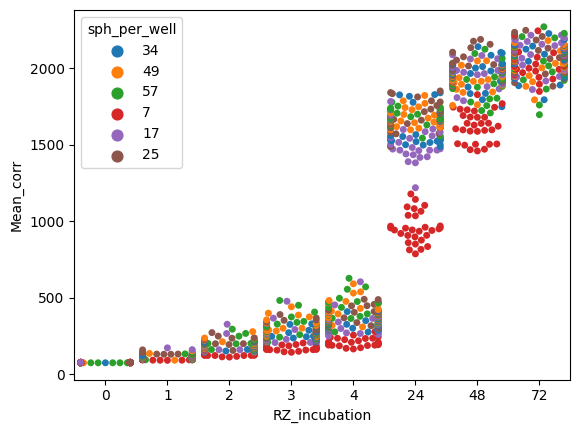

In [70]:
ay = sns.swarmplot(data=data_plate_wo_blank, x="RZ_incubation", y="Mean_corr", hue = 'sph_per_well')

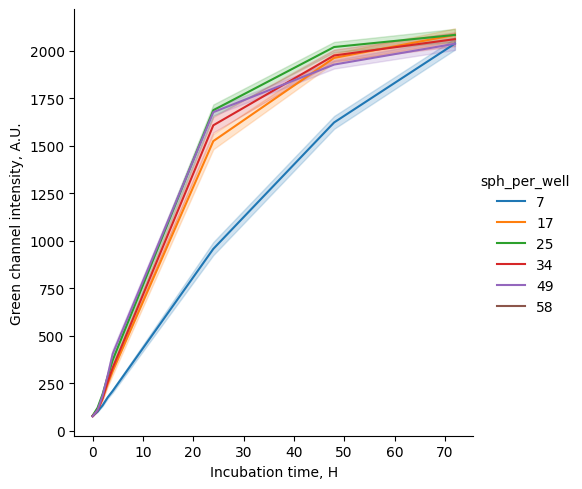

In [76]:
data_plate_wo_blank['RZ_incubation'] = pd.to_numeric(data_plate_wo_blank['RZ_incubation'])

ay = sns.relplot(data=data_plate_wo_blank, x="RZ_incubation", y="Mean_corr", hue = 'sph_per_well',  kind="line", 
                 hue_order = ['7', '17', '25','34','49','58'])

ay.set(xlabel='Incubation time, H', ylabel='Green channel intensity, A.U.')

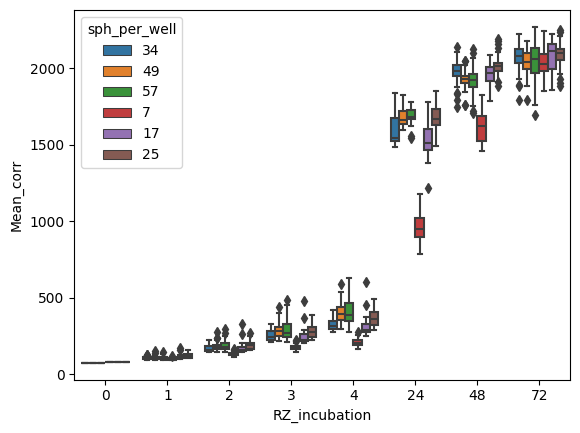

In [74]:
ay = sns.boxplot(data=data_plate_wo_blank, x="RZ_incubation", y="Mean_corr", hue = 'sph_per_well')

In [ ]:
file_name = part_to_folder + '/data_processed.csv'

data_plate_with_control.to_csv(file_name)